Video-tutorial in the Youtube channel BioPrograma
https://youtu.be/eQAJ4Jb1V1s
https://www.youtube.com/channel/UCbJAU7N9FYvwkdgSwD_1S4Q

In [2]:
#to reproduce the same environment I used  for this notebook
#conda env create -f cellpose_bruni.yml

In [5]:
# import os
import glob
# import matplotlib.pyplot as plt
# from cellpose import models, io
from skimage.io import imread, imshow, imsave 
from skimage.measure import regionprops_table
import matplotlib
import pandas as pd
import re
import seaborn

In [ ]:
os.chdir('BioPrograma/0005_automacao_extracao_de_numeros_a_partir_de_imagens/')
print(os.getcwd())

# Automation for Cellpose segmentation

In [ ]:
nucleo_files = np.sort(glob.glob('BBBC014_v1_images/*Channel 2*.Bmp'))

#make label folder
!mkdir label_folder
# Define the label_folder
label_folder = 'label_folder/' # replace with your actual folder path

# load the cellpose model outside the loop
model = models.Cellpose(gpu=True, model_type='nuclei') #if you do not have GPU on your computer, use replace True for False in the code
channels = [0,0] # This means we are processing single channel greyscale images for cellpose


for i in nucleo_files:
    nucleo_ch1 = imread(i)
    print("Processing image:", i)
    # apply cellpose model
    label_image, flows, styles, diams = model.eval(nucleo_ch1, flow_threshold=0.8, diameter=10, channels=channels)
    
    #save label images in a folder
    #save label_image as tiff
    imsave(os.path.join(label_folder,  f"{os.path.splitext(os.path.basename(i))[0]}.tiff"), label_image)
   

In [14]:
#new random cmap
def random_cmap():
    np.random.seed(42)
    cmap = matplotlib.colors.ListedColormap (np.random.rand(4096,4))
    # value 0 should just be transparent
    cmap.colors[:,3] = 0.5
    cmap.colors[0,:] = 1
    cmap.colors[0,3] = 0


    # if image is a mask, color (last value) should be red
    cmap.colors[-1,0] = 1
    cmap.colors[-1,1:3] = 0
    return cmap


cmap = random_cmap()  

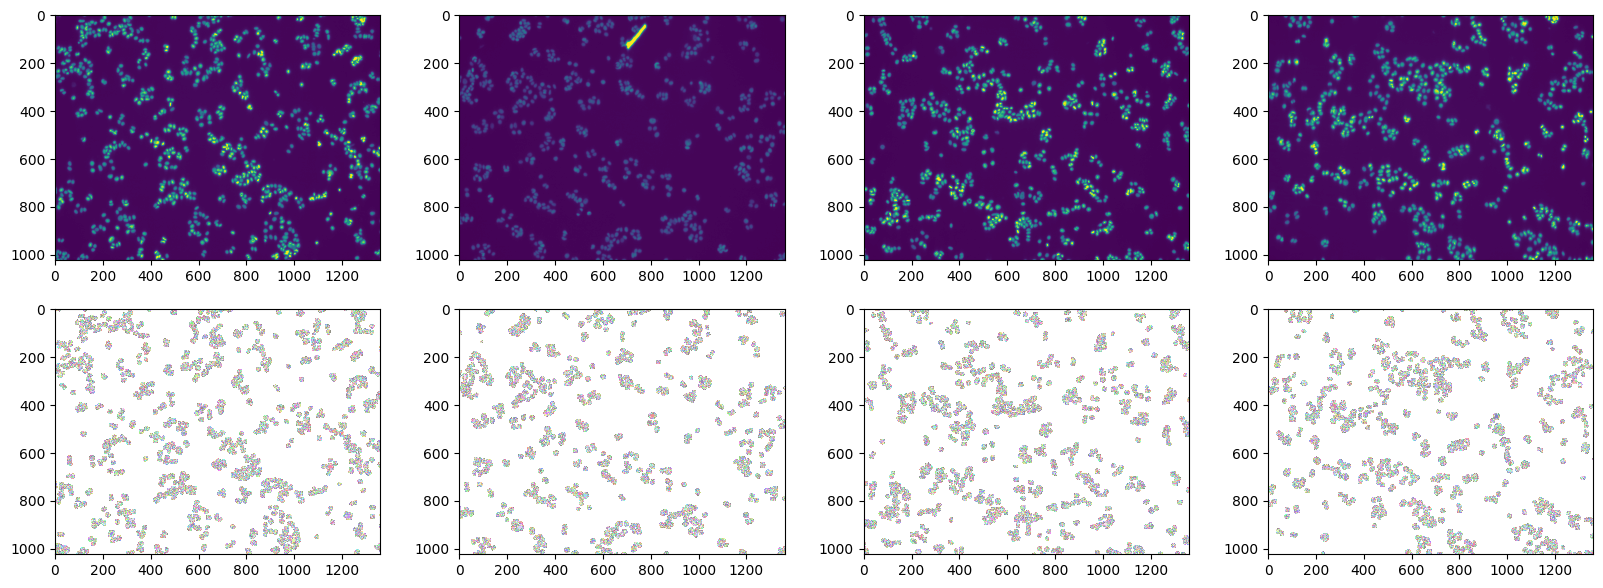

In [18]:

#visualize some pairs of images

figs, axs = plt.subplots(2,4, figsize=(20,7))
axs[0,0].imshow(imread('BBBC014_v1_images/Channel 2-09-A-09-00.Bmp'))
axs[0,1].imshow(imread('BBBC014_v1_images/Channel 2-01-A-01-00.Bmp'))
axs[0,2].imshow(imread('BBBC014_v1_images/Channel 2-04-A-04-00.Bmp'))
axs[0,3].imshow(imread('BBBC014_v1_images/Channel 2-06-A-06-00.Bmp'))
axs[1,0].imshow(imread('label_folder/Channel 2-09-A-09-00.tiff'), cmap=cmap)
axs[1,1].imshow(imread('label_folder/Channel 2-01-A-01-00.tiff'), cmap=cmap)
axs[1,2].imshow(imread('label_folder/Channel 2-04-A-04-00.tiff'), cmap=cmap)
axs[1,3].imshow(imread('label_folder/Channel 2-06-A-06-00.tiff'), cmap=cmap)

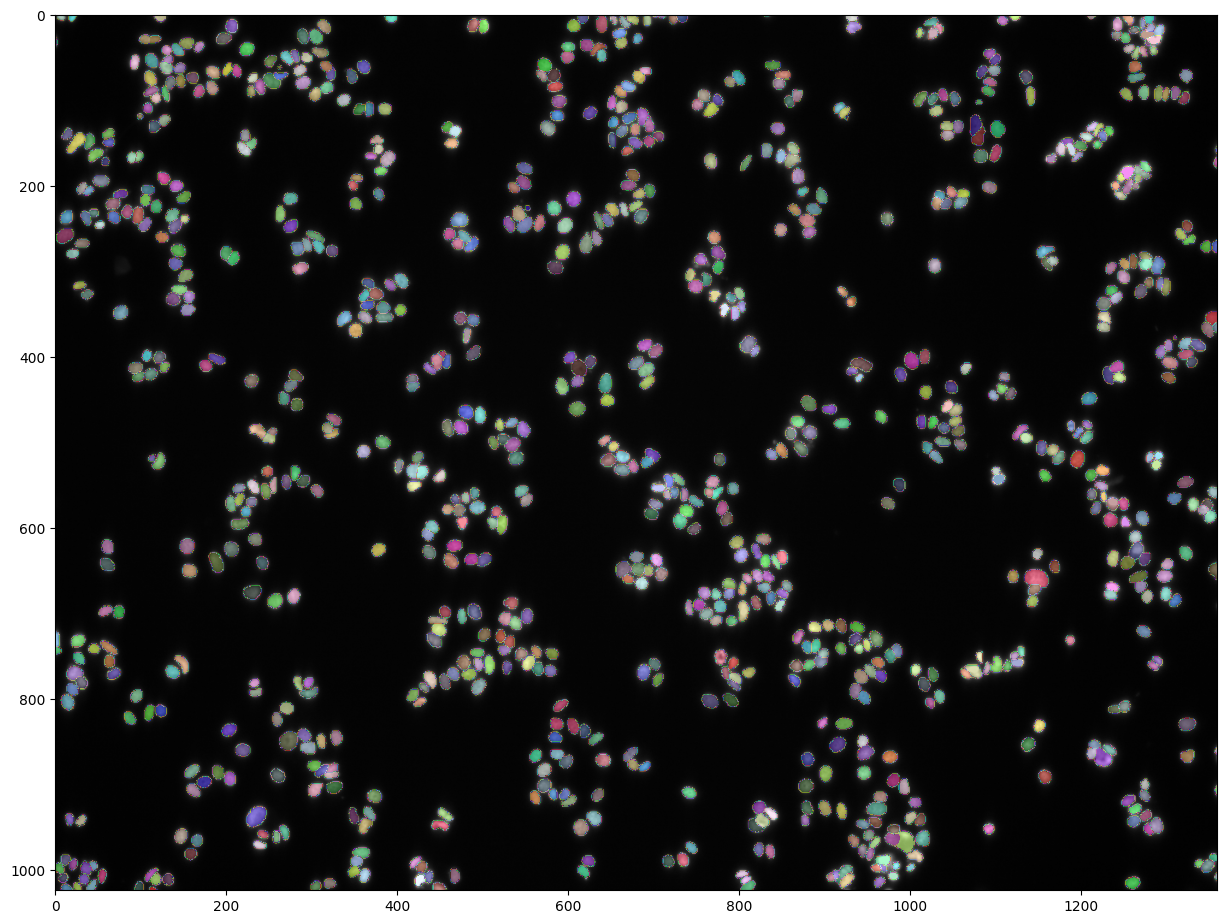

In [45]:
plt.figure(figsize=(15,15))
plt.imshow(imread('BBBC014_v1_images/Channel 2-09-A-09-00.Bmp'), cmap='gray')# by using this, [200:800,200:800], we reduce the area we see (a zoom-like)
plt.imshow(imread('label_folder/Channel 2-09-A-09-00.tiff'), cmap=cmap)

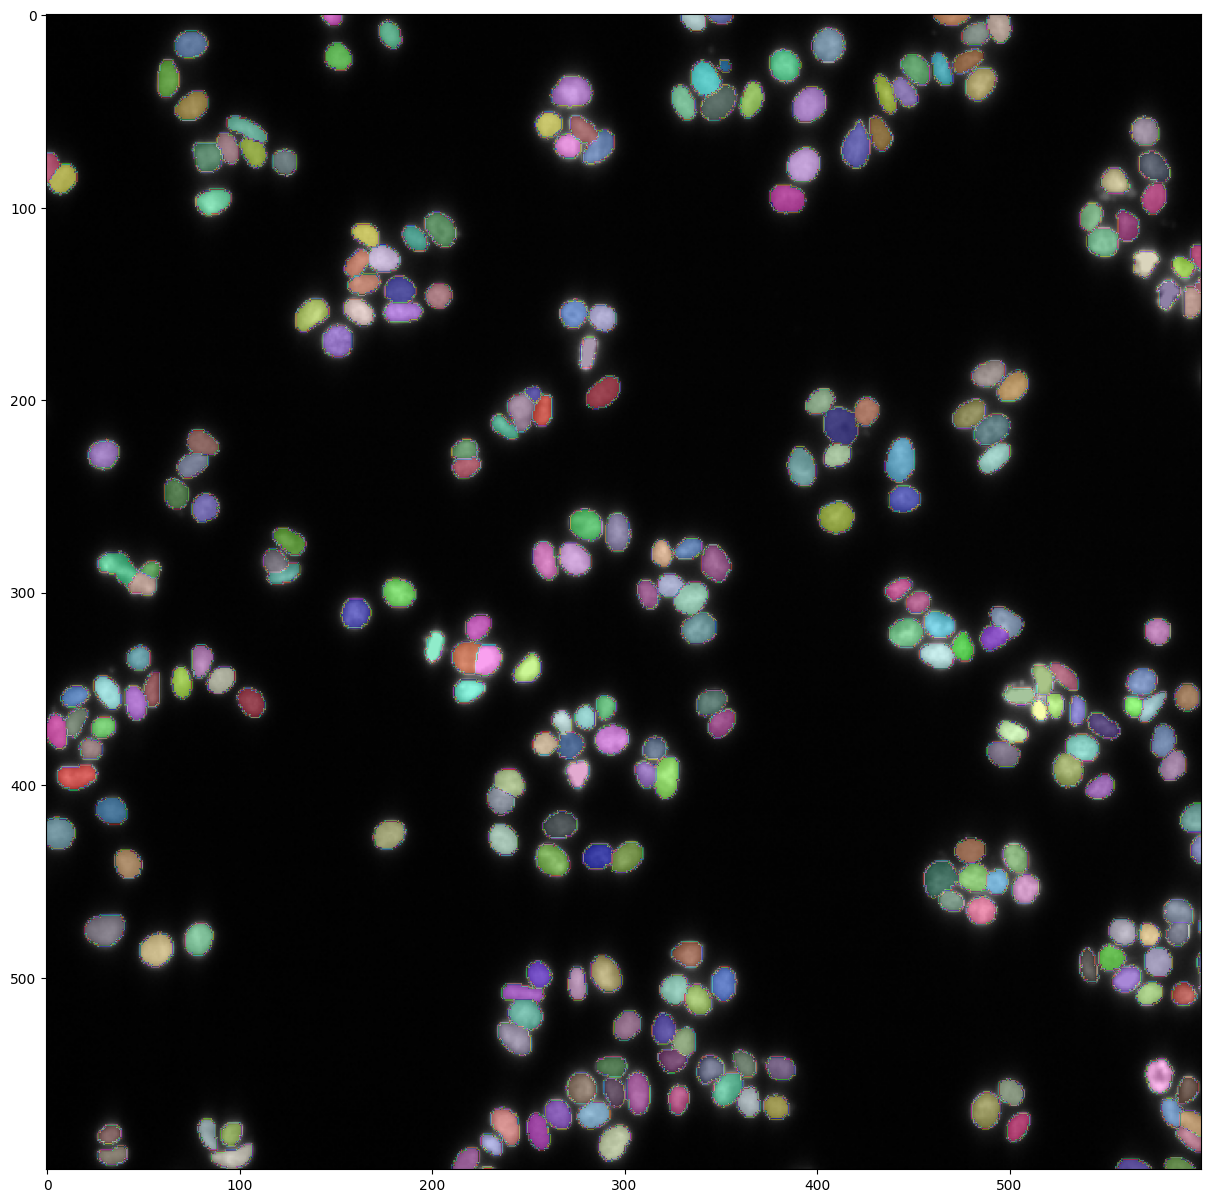

In [46]:
plt.figure(figsize=(15,15))
plt.imshow(imread('BBBC014_v1_images/Channel 2-09-A-09-00.Bmp')[200:800,200:800], cmap='gray')# by using this, [200:800,200:800], we reduce the area we see (a zoom-like)
plt.imshow(imread('label_folder/Channel 2-09-A-09-00.tiff')[200:800,200:800], cmap=cmap)

# Automation for measurements

In [6]:

#This code was largely based on #https://github.com/guiwitz/neubias_academy_biapy/blob/master/16-Experiment_analysis.ipynb
#BSD 3-Clause License Copyright (c) 2021, University of Bern, Mathematical Institute and Microscopy Imaging Center, Guillaume Witz


target_files = np.sort(glob.glob('BBBC014_v1_images/*Channel 1*.Bmp'))
label_files = np.sort(glob.glob('label_folder/*Channel 2*.tiff'))
results =[]

properties ='label', 'area', 'mean_intensity'

for i in range(len(label_files)):
    label_images = imread(label_files[i])
    target_ch1 = imread(target_files[i])
    
   
    #the function regionprops_table takes the label images, the intensity_image (channel I want to measure fluorescence) and properties (what I want to measure)
    data = regionprops_table(label_images, intensity_image=target_ch1,  properties =properties)
    
      # convert data to a table of measurements 
    # https://pandas.pydata.org/docs/getting_started/
    
    df = pd.DataFrame(data)
  
    '''we need to get the ids of each image. Get this info from the file names.
    Get the replicate (rep1, rep2, etc)  and get conditions (control or treated, for example)
    For that or that we will use regular expressions https://docs.python.org/3/library/re.html'''
   
    df['filename'] = target_files[i].split('\\')[1]
    df['condition'] = re.findall('.+ .+-.+-.+-(.+)-.+.Bmp', target_files[i].split('\\')[1])[0]
    df['technical_replicate'] = condition= re.findall('.+ .+-.+-(.+)-.+-.+.Bmp', target_files[i].split('\\')[1])[0]

       
    #append results - make a list of dfs
    results.append(df)


In [150]:
#file names 'Channel 1-48-D-12-00.Bmp'
#MCF7 in the wells A to D. Exclude E-H wells from the folder to reproduce this notebook
#A to D -12, control
#A to D -01, treated


In [54]:
results[11]

,label,area,mean_intensity,filename,condition,technical_replicate
0,1,124,40.564516,Channel 1-12-A-12-00.Bmp,12,A
1,2,107,79.373832,Channel 1-12-A-12-00.Bmp,12,A
2,3,95,45.368421,Channel 1-12-A-12-00.Bmp,12,A
3,4,184,28.510870,Channel 1-12-A-12-00.Bmp,12,A
4,5,84,40.523810,Channel 1-12-A-12-00.Bmp,12,A
...,...,...,...,...,...,...
748,749,127,69.543307,Channel 1-12-A-12-00.Bmp,12,A
749,750,44,34.840909,Channel 1-12-A-12-00.Bmp,12,A
750,751,33,28.696970,Channel 1-12-A-12-00.Bmp,12,A
751,752,29,71.103448,Channel 1-12-A-12-00.Bmp,12,A


In [7]:
all_results = pd.concat(results)

In [195]:
all_results

,label,area,mean_intensity,filename,condition,technical_replicate
0,1,18,90.222222,Channel 1-01-A-01-00.Bmp,01,A
1,2,79,102.848101,Channel 1-01-A-01-00.Bmp,01,A
2,3,166,85.783133,Channel 1-01-A-01-00.Bmp,01,A
3,4,180,88.888889,Channel 1-01-A-01-00.Bmp,01,A
4,5,86,130.011628,Channel 1-01-A-01-00.Bmp,01,A
...,...,...,...,...,...,...
678,679,90,100.866667,Channel 1-48-D-12-00.Bmp,12,D
679,680,94,64.989362,Channel 1-48-D-12-00.Bmp,12,D
680,681,52,34.730769,Channel 1-48-D-12-00.Bmp,12,D
681,682,46,110.978261,Channel 1-48-D-12-00.Bmp,12,D


In [8]:
pd.DataFrame.to_csv(all_results, 'all_results.csv')

# Automation for Cellpose segmentation and measurements

In [ ]:
#This code was largely based on #https://github.com/guiwitz/neubias_academy_biapy/blob/master/16-Experiment_analysis.ipynb
#BSD 3-Clause License Copyright (c) 2021, University of Bern, Mathematical Institute and Microscopy Imaging Center, Guillaume Witz

target_files = np.sort(glob.glob('BBBC014_v1_images/*Channel 1*.Bmp'))
nucleo_files = np.sort(glob.glob('BBBC014_v1_images/*Channel 2*.Bmp'))

#make label folder
!mkdir label_folder
# Define the label_folder
label_folder = '/BioPrograma/0005_automacao_extracao_de_numeros_a_partir_de_imagens/label_folder/' # replace with your actual folder path

# load the cellpose model outside the loop
model = models.Cellpose(gpu=True, model_type='nuclei') #if you do not have GPU on your computer, use replace True for False in the code
channels = [0,0] # This means we are processing single channel greyscale images for cellpose

properties ='label', 'area', 'mean_intensity' #paremeters that you want to measure with properties

results=[] #a list that will contain the dataframes with the results


for i in range(len(nucleo_files)):
    nucleo_ch1 = imread(nucleo_files[i])
    
    # apply cellpose model
    label_image, flows, styles, diams = model.eval(nucleo_ch1, flow_threshold=0.8, diameter=10, channels=channels)
    
    #save label images in a folder
    imsave(os.path.join(label_folder, os.path.splitext(os.path.basename(nucleo_files[i]))[0] + ".tiff"), label_image)
   
    target_ch1 = imread(target_files[i])
    
    #function regionprops_table takes the label images, the intensity_image (channel I want to measure fluorescence) and properties (what I want to measure)
    data = regionprops_table(label_image, intensity_image=target_ch1,  properties =properties)
    
    # convert data to a table of measurements 
    df = pd.DataFrame(data)
    
    #we need to get the ids of each image. Get this info from the file names.
    #Get the replicate (rep1, rep2, etc)  and get conditions (control or treated, for example)
    df['filename'] = target_files[i].split('\\')[1]
    df['condition'] = re.findall('.* .*-.*-.*-(.*)-.*.Bmp', target_files[i].split('\\')[1])[0]
    df['technical_replicate'] = re.findall('.* .*-.*-(.*)-.*-.*.Bmp', target_files[i].split('\\')[1])[0]

    #append results - make a list of dfs
    results.append(df)

all_results = pd.concat(results)
all_results.to_csv('all_results.csv')


<AxesSubplot: xlabel='condition', ylabel='mean_intensity'>

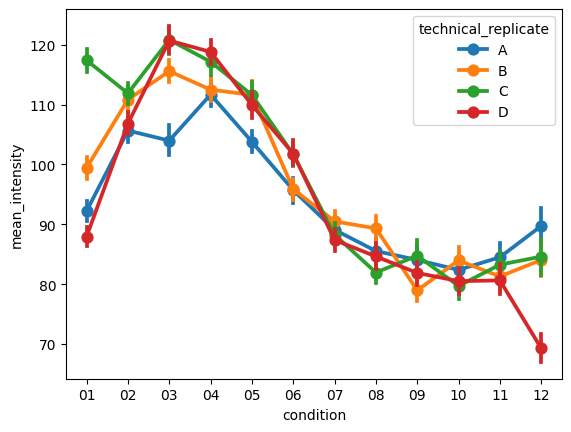

In [42]:
#plot a graph with seaborn
sns.pointplot(data=all_results, x='condition', y='mean_intensity', 
              hue='technical_replicate')